In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
path_to_working_dir = "/global/cfs/cdirs/m3246/rmastand/bkg_extrap/redo/"
gen_seed = 1
n_context = 2
n_samples = 30000 #ideal bkg and data tend to be rather large

static_data_dir = f"{path_to_working_dir}/data/"
seeded_data_dir = f"{path_to_working_dir}/data/seed{gen_seed}/"
samples_dir = f"{path_to_working_dir}/samples/seed{gen_seed}/"
eval_dir = f"{path_to_working_dir}/evaluation/seed{gen_seed}/"

### CR closure

In [14]:
keys_to_plot = ["Ideal", "Reweight"]

samples_cr_dict = {}
weights_cr_dict = {}

samples_sr_dict = {}
weights_sr_dict = {}

samples_cr_dict["truth"] = np.load(f"{seeded_data_dir}/data_0.npz")["data_events_cr"][:n_samples,n_context:]
weights_cr_dict["truth"] = None
samples_sr_dict["truth"] = np.load(f"{seeded_data_dir}/data_0.npz")["data_events_sr"][:n_samples,n_context:]
weights_sr_dict["truth"] = None

if "Ideal" in keys_to_plot:
    samples_cr_dict["Ideal"] = np.load(f"{static_data_dir}/ideal_bkg_events.npz")["ideal_bkg_events_cr"][:n_samples,n_context:]
    weights_cr_dict["Ideal"] = None
    samples_sr_dict["Ideal"] = np.load(f"{static_data_dir}/ideal_bkg_events.npz")["ideal_bkg_events_sr"][:n_samples,n_context:]
    weights_sr_dict["Ideal"] = None

if "Reweight" in keys_to_plot:
    samples_cr_dict["Reweight"] = np.load(f"{samples_dir}/reweight_CR_closure_s0.npz")["mc_cr"][:,n_context:]
    weights_cr_dict["Reweight"] = np.load(f"{samples_dir}/reweight_CR_closure_s0.npz")["w_cr"]
    samples_sr_dict["Reweight"] = np.load(f"{samples_dir}/reweight_SR_s0.npz")["mc_samples"][:,n_context:]
    weights_sr_dict["Reweight"] = np.load(f"{samples_dir}/reweight_SR_s0.npz")["w_sr"]
    
if "Generate" in keys_to_plot:
    samples_cr_dict["Generate"] = np.load(f"{samples_dir}/generate_CR_closure_s0.npz")["generate_cr"][:]
    print(samples_cr_dict["Generate"].shape)
    weights_cr_dict["Generate"] = None # No weights here -- cr is sampled using data
    samples_sr_dict["Generate"] = np.load(f"{samples_dir}/generate_SR_s0.npz")["samples"][:,n_context:]
    weights_sr_dict["Generate"] = np.load(f"{samples_dir}/context_weights_SR_s0.npz")["w_sr"]
    
if "Morph" in keys_to_plot:
    samples_cr_dict["Morph"] = np.load(f"{samples_dir}/morph_CR_closure_s0.npz")["morph_cr"][:,n_context:]
    weights_cr_dict["Morph"] = np.load(f"{samples_dir}/context_weights_CR_closure_s0.npz")["w_cr"]
    samples_sr_dict["Morph"] = np.load(f"{samples_dir}/morph_SR_s0.npz")["samples"][:,n_context:]
    weights_sr_dict["Morph"] = np.load(f"{samples_dir}/context_weights_SR_s0.npz")["w_sr"]


In [15]:
def name_map():
    return {
        "m_jj": "$m_{{\\rm jj}}$",
        "met": "MET",
        "ht": "HT",
        "pT_j1": "Leading jet $p_{{\\rm T}}$",
        "pT_j2": "Sub-leading jet $p_{{\\rm T}}$",
        "tau21_j1": "Leading jet $\\tau_2/\\tau_1$",
        "tau21_j2": "Sub-leading jet $\\tau_2/\\tau_1$",
        "tau32_j1": "Leading jet $\\tau_3/\\tau_2$",
        "tau32_j2": "Sub-leading jet $\\tau_3/\\tau_2$",
        "min_dPhi": "min$\\Delta\\phi(\\rm j_i, \\rm MET)$",
    }

var_names = ["m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]
names = name_map()

xlabel_list = [] 
for x in var_names:
    xlabel_list.append(f"{names[x]}")

colors_dict = {"fullsup":"grey",
               "Reweight": "forestgreen",
               "Morph": "mediumvioletred",
               "Generate":"darkgoldenrod",
                "Ideal":"darkblue",
                "truth":"lightblue"}

bins = np.linspace(-2.5, 2.5, 30)
bin_centers = 0.5*(bins[1:] + bins[:-1] )

f1 = 24
f2 = 20

n_features = 5

## Plot CR Closure

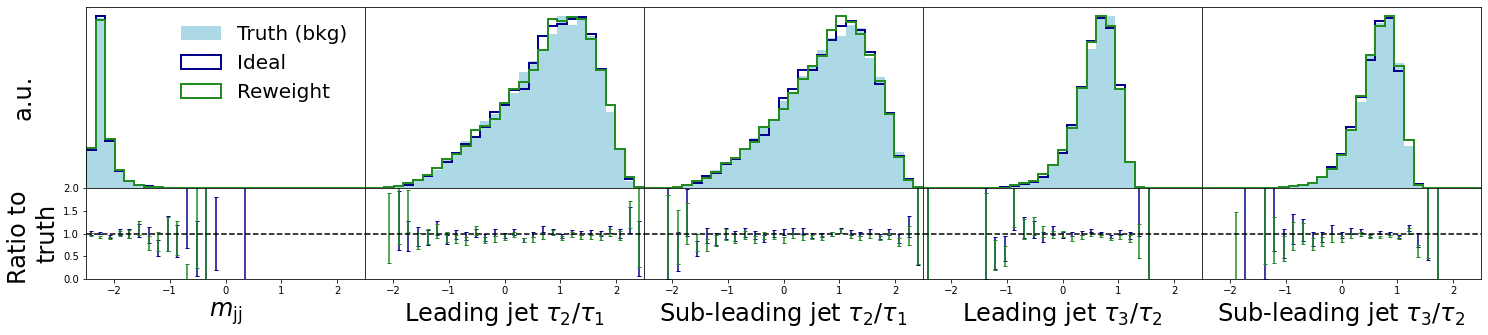

In [16]:
# features
np.seterr(divide='ignore', invalid='ignore')

fig, ax = plt.subplots(2, n_features, figsize = (5*n_features, 1*n_features), height_ratios=[2, 1])

for i in range(n_features):
    
    # hist
    truth_density , _,_ = ax[0,i].hist(samples_cr_dict["truth"][:,i], color = colors_dict["truth"], bins = bins, label = "Truth (bkg)", density = True)
    hist_denom, _ = np.histogram(samples_cr_dict["truth"][:,i], bins = bins, density = False)
    errors_denom = np.sqrt(hist_denom)
    ax[0,i].set_xlim(-2.5, 2.5)
    
    for k in keys_to_plot:
        

        loc_density, _ ,_ = ax[0,i].hist(samples_cr_dict[k][:,i], bins = bins, label = k, histtype = "step", density = True, color = colors_dict[k], lw = 2, weights = weights_cr_dict[k])
        loc_hist, _ = np.histogram(samples_cr_dict[k][:,i], bins = bins, density = False, weights = weights_cr_dict[k])

        
        loc_errors = np.sqrt(loc_hist)
        loc_ratio = loc_hist/hist_denom
        loc_errors_ratio = np.sqrt ( (errors_denom/hist_denom)**2 + (loc_errors/loc_hist)**2 ) * loc_ratio
        ax[1,i].errorbar(bin_centers, loc_ratio, yerr = loc_errors_ratio, linestyle = "", color = colors_dict[k], capsize = 2)

    ax[1,i].set_xlabel(xlabel_list[i], fontsize = f1)
    ax[1,i].axhline(1, color = "black", linestyle = "dashed")
    ax[1,i].set_xlim(-2.5, 2.5)
    
    ax[1,i].set_xticks(np.arange(-2, 3, 1))
    ax[1,i].set_ylim(0, 2)
    
    
ax[0,0].set_ylabel("a.u.", fontsize = f1, labelpad = 50)
ax[0,0].set_yticks([])
ax[1,0].set_ylabel("Ratio to \ntruth", fontsize = f1)

for i in range(1, n_features):
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])


ax[0,0].legend(frameon = False, fontsize = f2) 


plt.subplots_adjust(wspace = 0, hspace = 0)
plt.savefig("../plots/physics_features_ratios_CR.pdf")
plt.show()



## Plot SR closure

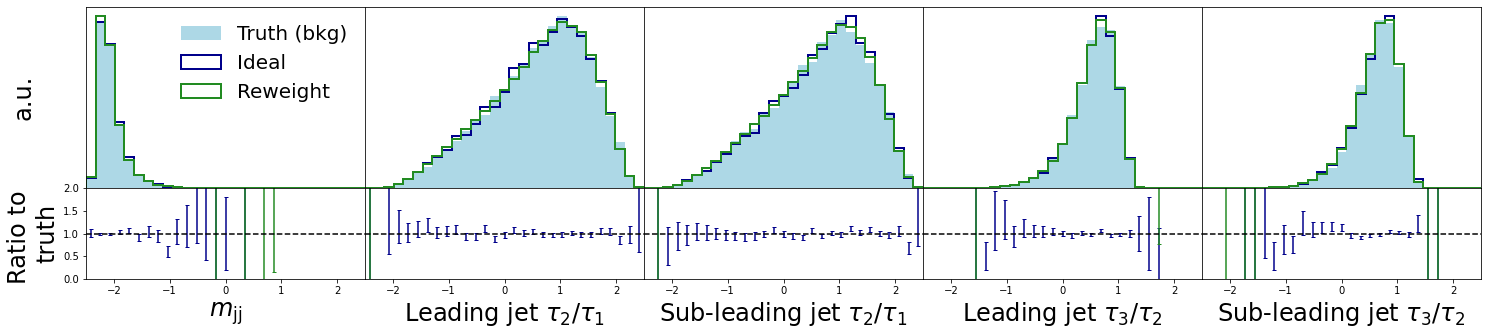

In [17]:
# features
np.seterr(divide='ignore', invalid='ignore')

fig, ax = plt.subplots(2, n_features, figsize = (5*n_features, 1*n_features), height_ratios=[2, 1])

for i in range(n_features):
    
    # hist
    truth_density , _,_ = ax[0,i].hist(samples_sr_dict["truth"][:,i], color = colors_dict["truth"], bins = bins, label = "Truth (bkg)", density = True)
    hist_denom, _ = np.histogram(samples_sr_dict["truth"][:,i], bins = bins, density = False)
    errors_denom = np.sqrt(hist_denom)
    ax[0,i].set_xlim(-2.5, 2.5)
    
    for k in keys_to_plot:
        

        loc_density, _ ,_ = ax[0,i].hist(samples_sr_dict[k][:,i], bins = bins, label = k, histtype = "step", density = True, color = colors_dict[k], lw = 2, weights = weights_sr_dict[k])
        loc_hist, _ = np.histogram(samples_sr_dict[k][:,i], bins = bins, density = False, weights = weights_sr_dict[k])

        
        loc_errors = np.sqrt(loc_hist)
        loc_ratio = loc_hist/hist_denom
        loc_errors_ratio = np.sqrt ( (errors_denom/hist_denom)**2 + (loc_errors/loc_hist)**2 ) * loc_ratio
        ax[1,i].errorbar(bin_centers, loc_ratio, yerr = loc_errors_ratio, linestyle = "", color = colors_dict[k], capsize = 2)

    ax[1,i].set_xlabel(xlabel_list[i], fontsize = f1)
    ax[1,i].axhline(1, color = "black", linestyle = "dashed")
    ax[1,i].set_xlim(-2.5, 2.5)
    
    ax[1,i].set_xticks(np.arange(-2, 3, 1))
    ax[1,i].set_ylim(0, 2)
    
    
ax[0,0].set_ylabel("a.u.", fontsize = f1, labelpad = 50)
ax[0,0].set_yticks([])
ax[1,0].set_ylabel("Ratio to \ntruth", fontsize = f1)

for i in range(1, n_features):
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])


ax[0,0].legend(frameon = False, fontsize = f2) 


plt.subplots_adjust(wspace = 0, hspace = 0)
plt.savefig("../plots/physics_features_ratios_CR.pdf")
plt.show()



## AUC Spread

ValueError: 'yerr' must not contain negative values

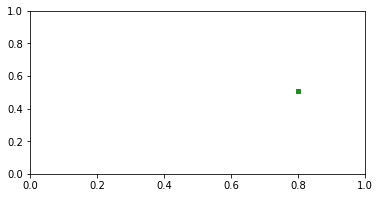

In [18]:


keys_to_plot = ["Reweight", "Generate", "Morph", "Ideal"]
centers = [1, 2, 3, 4]


med_AUC_cr = {"Reweight":0.5076248000000001, 
              "Generate":0.5228918224999999, 
              "Morph":0.5156505375, 
              "Ideal":0.5021822775}

percentiles_AUC_cr = {"Reweight":[0,0 ],   # 16, 84
                 "Generate":[0, 0], 
                 "Morph":[0,0], 
                 "Ideal":[0,0]}

med_AUC_sr = {"Reweight":0, 
              "Generate":0, 
              "Morph":0, 
              "Ideal":0}
percentiles_AUC_cr = {"Reweight":[0, 0], 
                 "Generate":[0,0], 
                 "Morph":[0,0], 
                 "Ideal":[0,0]}


plt.figure(figsize = (6, 3))
m = 4
lw = 1

for i, k in enumerate(keys_to_plot):
    
    # CR
    plt.errorbar(centers[i]-0.2, med_AUC_cr[k], yerr = np.array([med_AUC_cr[k]-percentiles_AUC_cr[k][0], percentiles_AUC_cr[k][1]-med_AUC_cr[k]]).reshape(2,1), fmt = "s", color = colors_dict[k], markersize = m, elinewidth=lw)
    
    # SR
    plt.errorbar(centers[i]+0.2, med_AUC_sr[k], yerr = [med_AUC_sr[k]-percentiles_AUC_sr[k][0], percentiles_AUC_sr[k][1]-med_AUC_cr[k]], fmt = "D", color = colors_dict[k], markersize = m, elinewidth=lw)
    
    plt.text(centers[i], .45, k, color  = colors_dict[k], fontsize = f1, horizontalalignment = "center")

plt.xticks([])
plt.yticks(np.arange(0.4, 0.65, 0.05))

plt.errorbar(-4, -1, fmt = "s", color = "k", label = "CR", markersize = m)
plt.errorbar(-4, -1, fmt = "D", color = "k", label = "SR", markersize = m)
plt.axhline(0.5, linestyle = "dashed", color = "grey", lw = 3)


plt.legend(frameon = False, fontsize = 12, loc = "upper right")

plt.xlim([0.5, 4.5])
plt.ylim([0.42, 0.58])
plt.savefig("../plots/aucs_physics.pdf")

plt.show()